# Model recovery analysis
#### Florian Ott, 2022

Here we test the range of parameter values for which the hybrid model (*HM (I)P+S (E)P+S 2beta*) is distinguishable from the planning model (*PM (I)P (E)P*) and the simple model (*SM (I)S (E)S*). Note that we used a non-hierarchical version of the HM, PM and SM, which allows us to demonstrate model distinguishability at moderate computational expense. Please refer to the manuscript for further explanation.

In [1]:
import numpy as np
import pandas as pd
import pystan
import arviz as az
import glob as glob
import time as time
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
plt.style.use('ara')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Load particpant data 
filename = glob.glob('../data/behaviour/data_all_participants_20220215120148.csv') 
dat = pd.read_csv(filename[0],index_col = 0)

## Load model data
# Posterior mean and credibility intervals of estimated parameters
with open("../data/model/summary_HM_20220216143030.pkl", "rb") as f:
    summary_hybrid = pickle.load(f)['summary']

idx = dat['timeout'] == 0
dat_subset = dat.loc[idx]

# Specifying the models 

In [2]:
# Stan code for the flat version of the PM
flat_m1 = '''
data {
  int<lower=0> N;
  int<lower=0,upper=1> response[N];
  vector[N] dv;
  vector[N] is_basic;
  vector[N] is_full_energy;
  vector[N] is_low_energy_LC;
  vector[N] is_low_energy_HC;
}

parameters {
  real theta_basic;
  real theta_full_energy;
  real theta_low_energy_LC;
  real theta_low_energy_HC;
  real beta_dv;
}

model {
  theta_basic ~ normal(0, 2);
  theta_full_energy ~ normal(0, 2);
  theta_low_energy_LC ~ normal(0, 2);
  theta_low_energy_HC ~ normal(0, 2);
  beta_dv ~ normal(0, 2);  

  response ~ bernoulli_logit(theta_full_energy * is_full_energy + theta_low_energy_LC * is_low_energy_LC + theta_low_energy_HC * is_low_energy_HC + theta_basic * is_basic + beta_dv * dv);
}

generated quantities {
  vector[N] log_lik;
  vector[N] response_new;

// pointwise log-likelihood
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf(response[n]  |  (theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic * is_basic[n] + beta_dv * dv[n]));
    }

// posterior predictive simulation  

  for (n in 1:N){
    response_new[n] = bernoulli_logit_rng(theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic * is_basic[n] + beta_dv * dv[n]);
    } 
}
'''

In [3]:
# Stan code for the flat version of the HM model
flat_m2 = '''
data {
  int<lower=0> N;
  int<lower=0,upper=1> response[N];
  vector[N] dv;
  vector[N] is_basic_1;
  vector[N] is_basic_2;
  vector[N] is_basic_3;
  vector[N] is_basic_4;
  vector[N] is_23;
  vector[N] is_14;
  vector[N] is_full_energy;
  vector[N] is_low_energy_LC;
  vector[N] is_low_energy_HC;
}

parameters {
  real theta_basic_1;
  real theta_basic_2;
  real theta_basic_3;
  real theta_basic_4;
  real theta_full_energy;
  real theta_low_energy_LC;
  real theta_low_energy_HC;
  real beta_dv_23;
  real beta_dv_14;

}

model {
// priors
  theta_basic_1 ~ normal(0,2);
  theta_basic_2 ~ normal(0,2);
  theta_basic_3 ~ normal(0,2);
  theta_basic_4 ~ normal(0,2);
  theta_full_energy ~ normal(0,2);
  theta_low_energy_LC ~ normal(0,2);
  theta_low_energy_HC ~ normal(0,2);
  beta_dv_23 ~ normal(0,2);  
  beta_dv_14 ~ normal(0,2);  


// likelihood 
  response ~ bernoulli_logit(theta_full_energy * is_full_energy + theta_low_energy_LC * is_low_energy_LC + theta_low_energy_HC * is_low_energy_HC + theta_basic_1 * is_basic_1 + theta_basic_2 * is_basic_2 + theta_basic_3 * is_basic_3 + theta_basic_4 * is_basic_4 + beta_dv_23 * dv .* is_23 + beta_dv_14 * dv .* is_14);
}

generated quantities {
  vector[N] log_lik;
  vector[N] response_new;

// pointwise log-likelihood
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf(response[n]  |  (theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1  * is_basic_1[n] + theta_basic_2  * is_basic_2[n] + theta_basic_3  * is_basic_3[n] + theta_basic_4 * is_basic_4[n] + beta_dv_23 * dv[n] * is_23[n] + beta_dv_14 * dv[n] * is_14[n] ));
    }

// posterior predictive simulation  

  for (n in 1:N){
    response_new[n] = bernoulli_logit_rng(theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1  * is_basic_1[n] + theta_basic_2  * is_basic_2[n] + theta_basic_3 * is_basic_3[n] + theta_basic_4 * is_basic_4[n] + beta_dv_23  * dv[n] * is_23[n] + beta_dv_14  * dv[n] * is_14[n] );
    } 
}
'''

In [4]:
# Stan code for the flat version of the SM model
flat_m3 = '''
data {
  int<lower=0> N;
  int<lower=0,upper=1> response[N];
  vector[N] is_basic_1;
  vector[N] is_basic_2;
  vector[N] is_basic_3;
  vector[N] is_basic_4;
  vector[N] is_full_energy;
  vector[N] is_low_energy_LC;
  vector[N] is_low_energy_HC;
}

parameters {
  real theta_basic_1;
  real theta_basic_2;
  real theta_basic_3;
  real theta_basic_4;
  real theta_full_energy;
  real theta_low_energy_LC;
  real theta_low_energy_HC;
}

model {
// priors
  theta_basic_1 ~ normal(0,2);
  theta_basic_2 ~ normal(0,2);
  theta_basic_3 ~ normal(0,2);
  theta_basic_4 ~ normal(0,2);
  theta_full_energy ~ normal(0,2);
  theta_low_energy_LC ~ normal(0,2);
  theta_low_energy_HC ~ normal(0,2);

// likelihood 
  response ~ bernoulli_logit(theta_full_energy * is_full_energy + theta_low_energy_LC * is_low_energy_LC + theta_low_energy_HC * is_low_energy_HC + theta_basic_1 * is_basic_1 + theta_basic_2 * is_basic_2 + theta_basic_3 * is_basic_3 + theta_basic_4 * is_basic_4);
}

generated quantities {
  vector[N] log_lik;
  vector[N] response_new;

// pointwise log-likelihood
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf(response[n]  |  (theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1  * is_basic_1[n] + theta_basic_2  * is_basic_2[n] + theta_basic_3  * is_basic_3[n] + theta_basic_4 * is_basic_4[n] ));
    }

// posterior predictive simulation  

  for (n in 1:N){
    response_new[n] = bernoulli_logit_rng(theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1  * is_basic_1[n] + theta_basic_2  * is_basic_2[n] + theta_basic_3 * is_basic_3[n] + theta_basic_4 * is_basic_4[n]);
    } 
}
'''

## Compiling

In [5]:
sm_flat_m1 = pystan.StanModel(model_code=flat_m1,verbose = False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3f6ea7031342da4236663488ef0aea9 NOW.


In [6]:
sm_flat_m2 = pystan.StanModel(model_code=flat_m2,verbose = False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4424221ebd75a70e372f5027b9ef5bae NOW.


In [7]:
sm_flat_m3 = pystan.StanModel(model_code=flat_m3,verbose = False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f3cfc8e7fc0c4c06d40a9a06aed64a27 NOW.


# Vary preference parameters $\theta$

## Simulate novel responses

In [8]:
## Simulate novel data for refitting 
is_full_energy_rep = dat['is_full_energy'].to_numpy(dtype='int').squeeze()
is_low_energy_LC_rep = dat['is_low_energy_LC'].to_numpy(dtype='int').squeeze()
is_low_energy_HC_rep = dat['is_low_energy_HC'].to_numpy(dtype='int').squeeze()
is_basic_1_rep = dat['is_basic_1'].to_numpy(dtype='int').squeeze()
is_basic_2_rep = dat['is_basic_2'].to_numpy(dtype='int').squeeze()
is_basic_3_rep = dat['is_basic_3'].to_numpy(dtype='int').squeeze()
is_basic_4_rep = dat['is_basic_4'].to_numpy(dtype='int').squeeze()
is_basic_rep = dat['is_basic'].to_numpy(dtype='int').squeeze()
is_23_rep = dat['is_23'].to_numpy(dtype='int').squeeze()
is_14_rep = dat['is_14'].to_numpy(dtype='int').squeeze()
dv_rep = dat['dv_planning'].to_numpy().squeeze()

# Get posterior mean of group parameters and set range of parameters of interest
beta_dv_23_rep = summary_hybrid['mu_beta_dv_23']['mean'].to_numpy()
beta_dv_14_rep = summary_hybrid['mu_beta_dv_14']['mean'].to_numpy()
theta_basic_1_rep = np.arange(0,-6,-1)
theta_basic_2_rep = np.arange(0,-6,-1)
theta_basic_3_rep = np.arange(0,6)
theta_basic_4_rep = np.arange(0,6)
theta_full_energy_rep = summary_hybrid['theta_full_energy']['mean'].to_numpy()
theta_low_energy_HC_rep = summary_hybrid['theta_low_energy_HC']['mean'].to_numpy()
theta_low_energy_LC_rep = summary_hybrid['theta_low_energy_LC']['mean'].to_numpy()

# Sample novel binary responses
n_param_combinations = 6
response_rep = np.zeros((len(dat),n_param_combinations))
for i in range(n_param_combinations):
    logits_rep = theta_full_energy_rep * is_full_energy_rep + theta_low_energy_LC_rep * is_low_energy_LC_rep + theta_low_energy_HC_rep * is_low_energy_HC_rep + theta_basic_1_rep[i] * is_basic_1_rep + theta_basic_2_rep[i] * is_basic_2_rep + theta_basic_3_rep[i] * is_basic_3_rep + theta_basic_4_rep[i] * is_basic_4_rep + beta_dv_23_rep * dv_rep * is_23_rep + beta_dv_14_rep * dv_rep * is_14_rep
    p_rep = sigmoid(logits_rep) 
    response_rep[:,i] = stats.bernoulli.rvs(p_rep)
response_rep = np.array(response_rep,dtype=int)

## Specifying the data and sampling posterior

### Planning

In [9]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_planning']].to_numpy().squeeze()

looic_planning_i_vary_theta = np.zeros(n_param_combinations)
looic_planning_se_i_vary_theta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_planning = {'N':len(dv),         
                'response':response_rep[idx,i],
                'dv':dv, 
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic':is_basic
                } 


    res_planning = sm_flat_m1.sampling(data=dat_dict_planning, iter=2000,  warmup=1000, thin=1, chains=4,seed=101, verbose = False);
    idata_planning = az.from_pystan(posterior=res_planning,log_likelihood='log_lik')
    looic_planning = az.loo(idata_planning,pointwise=True,scale='deviance')
    looic_planning_i_vary_theta[i]=looic_planning[0]
    looic_planning_se_i_vary_theta[i]=looic_planning[1];

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Hybrid

In [10]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic_1 = dat.loc[idx,['is_basic_1']].to_numpy(dtype='int').squeeze()
is_basic_2 = dat.loc[idx,['is_basic_2']].to_numpy(dtype='int').squeeze()
is_basic_3 = dat.loc[idx,['is_basic_3']].to_numpy(dtype='int').squeeze()
is_basic_4 = dat.loc[idx,['is_basic_4']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
is_23 = dat.loc[idx,['is_23']].to_numpy(dtype='int').squeeze()
is_14 = dat.loc[idx,['is_14']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_planning']].to_numpy().squeeze()

looic_hybrid_i_vary_theta = np.zeros(n_param_combinations)
looic_hybrid_se_i_vary_theta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_hybrid= {'N':len(dv),         
                'response':response_rep[idx,i],
                'dv':dv,      
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic_1':is_basic_1,
                'is_basic_2':is_basic_2,
                'is_basic_3':is_basic_3,
                'is_basic_4':is_basic_4,
                'is_23':is_23,
                'is_14':is_14
                } 

    res_hybrid = sm_flat_m2.sampling(data=dat_dict_hybrid, iter=2000,  warmup=1000, thin=1, chains=4,control = control_dict,seed=101, verbose = False);
    idata_hybrid = az.from_pystan(posterior=res_hybrid,log_likelihood='log_lik')
    looic_hybrid = az.loo(idata_hybrid,pointwise=True,scale='deviance')
    looic_hybrid_i_vary_theta[i]=looic_hybrid[0]
    looic_hybrid_se_i_vary_theta[i]=looic_hybrid[1];

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Simple

In [11]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_simple']].to_numpy().squeeze()

looic_simple_i_vary_theta = np.zeros(n_param_combinations)
looic_simple_se_i_vary_theta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_simple = {'N':len(dv),         
                'response':response_rep[idx,i],
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic_1':is_basic_1,
                'is_basic_2':is_basic_2,
                'is_basic_3':is_basic_3,
                'is_basic_4':is_basic_4
                } 


    res_simple = sm_flat_m3.sampling(data=dat_dict_simple, iter=2000,  warmup=1000, thin=1, chains=4,seed=101, verbose = False);
    idata_simple = az.from_pystan(posterior=res_simple,log_likelihood='log_lik')
    looic_simple = az.loo(idata_simple,pointwise=True,scale='deviance')
    looic_simple_i_vary_theta[i]=looic_simple[0]
    looic_simple_se_i_vary_theta[i]=looic_simple[1]


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


# Vary planning weights $\beta_{plan}$

## Simulate novel responses

In [17]:
#%% Simulate novel data for refitting 
is_full_energy_rep = dat['is_full_energy'].to_numpy(dtype='int').squeeze()
is_low_energy_LC_rep = dat['is_low_energy_LC'].to_numpy(dtype='int').squeeze()
is_low_energy_HC_rep = dat['is_low_energy_HC'].to_numpy(dtype='int').squeeze()
is_basic_1_rep = dat['is_basic_1'].to_numpy(dtype='int').squeeze()
is_basic_2_rep = dat['is_basic_2'].to_numpy(dtype='int').squeeze()
is_basic_3_rep = dat['is_basic_3'].to_numpy(dtype='int').squeeze()
is_basic_4_rep = dat['is_basic_4'].to_numpy(dtype='int').squeeze()
is_basic_rep = dat['is_basic'].to_numpy(dtype='int').squeeze()
is_23_rep = dat['is_23'].to_numpy(dtype='int').squeeze()
is_14_rep = dat['is_14'].to_numpy(dtype='int').squeeze()
dv_rep = dat['dv_planning'].to_numpy().squeeze()

# Get posterior mean of group and individual paramters 
beta_dv_23_rep = np.arange(0,6)
beta_dv_14_rep = np.arange(0,6)
theta_basic_1_rep = summary_hybrid['mu_theta_basic_1']['mean'].to_numpy()
theta_basic_2_rep = summary_hybrid['mu_theta_basic_2']['mean'].to_numpy()
theta_basic_3_rep = summary_hybrid['mu_theta_basic_3']['mean'].to_numpy()
theta_basic_4_rep = summary_hybrid['mu_theta_basic_4']['mean'].to_numpy()
theta_full_energy_rep = summary_hybrid['theta_full_energy']['mean'].to_numpy()
theta_low_energy_HC_rep = summary_hybrid['theta_low_energy_HC']['mean'].to_numpy()
theta_low_energy_LC_rep = summary_hybrid['theta_low_energy_LC']['mean'].to_numpy()

# Sample novel binary responses based on posterior mean parameter values
n_param_combinations = 6
response_rep = np.zeros((len(dat),n_param_combinations))
for i in range(n_param_combinations):
    logits_rep = theta_full_energy_rep * is_full_energy_rep + theta_low_energy_LC_rep * is_low_energy_LC_rep + theta_low_energy_HC_rep * is_low_energy_HC_rep + theta_basic_1_rep * is_basic_1_rep + theta_basic_2_rep * is_basic_2_rep + theta_basic_3_rep * is_basic_3_rep + theta_basic_4_rep * is_basic_4_rep + beta_dv_23_rep[i] * dv_rep * is_23_rep + beta_dv_14_rep[i] * dv_rep * is_14_rep  
    p_rep = sigmoid(logits_rep) 
    response_rep[:,i] = stats.bernoulli.rvs(p_rep)
response_rep = np.array(response_rep,dtype=int)

## Specifying the data and sampling posterior

### Planning

In [18]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_planning']].to_numpy().squeeze()

looic_planning_i_vary_beta = np.zeros(n_param_combinations)
looic_planning_se_i_vary_beta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_planning = {'N':len(dv),         
                'response':response_rep[idx,i],
                'dv':dv, 
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic':is_basic
                } 


    res_planning = sm_flat_m1.sampling(data=dat_dict_planning, iter=2000,  warmup=1000, thin=1, chains=4,seed=101, verbose = False);
    idata_planning = az.from_pystan(posterior=res_planning,log_likelihood='log_lik')
    looic_planning = az.loo(idata_planning,pointwise=True,scale='deviance')
    looic_planning_i_vary_beta[i]=looic_planning[0]
    looic_planning_se_i_vary_beta[i]=looic_planning[1];

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Hybrid

In [19]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic_1 = dat.loc[idx,['is_basic_1']].to_numpy(dtype='int').squeeze()
is_basic_2 = dat.loc[idx,['is_basic_2']].to_numpy(dtype='int').squeeze()
is_basic_3 = dat.loc[idx,['is_basic_3']].to_numpy(dtype='int').squeeze()
is_basic_4 = dat.loc[idx,['is_basic_4']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
is_23 = dat.loc[idx,['is_23']].to_numpy(dtype='int').squeeze()
is_14 = dat.loc[idx,['is_14']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_planning']].to_numpy().squeeze()

looic_hybrid_i_vary_beta = np.zeros(n_param_combinations)
looic_hybrid_se_i_vary_beta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_hybrid= {'N':len(dv),         
                'response':response_rep[idx,i],
                'dv':dv,      
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic_1':is_basic_1,
                'is_basic_2':is_basic_2,
                'is_basic_3':is_basic_3,
                'is_basic_4':is_basic_4,
                'is_23':is_23,
                'is_14':is_14
                } 

    res_hybrid = sm_flat_m2.sampling(data=dat_dict_hybrid, iter=2000,  warmup=1000, thin=1, chains=4,control = control_dict,seed=101, verbose = False);
    idata_hybrid = az.from_pystan(posterior=res_hybrid,log_likelihood='log_lik')
    looic_hybrid = az.loo(idata_hybrid,pointwise=True,scale='deviance')
    looic_hybrid_i_vary_beta[i]=looic_hybrid[0]
    looic_hybrid_se_i_vary_beta[i]=looic_hybrid[1];

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Simple

In [20]:
control_dict = dict(adapt_delta=0.95)
idx = (dat['timeout'] == 0)
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic = dat.loc[idx,['is_basic']].to_numpy(dtype='int').squeeze()
dv = dat.loc[idx,['dv_simple']].to_numpy().squeeze()

looic_simple_i_vary_beta = np.zeros(n_param_combinations)
looic_simple_se_i_vary_beta = np.zeros(n_param_combinations)
for i in range(n_param_combinations):
    dat_dict_simple = {'N':len(dv),         
                'response':response_rep[idx,i],
                'is_full_energy':is_full_energy ,
                'is_low_energy_LC':is_low_energy_LC,
                'is_low_energy_HC':is_low_energy_HC,
                'is_basic_1':is_basic_1,
                'is_basic_2':is_basic_2,
                'is_basic_3':is_basic_3,
                'is_basic_4':is_basic_4
                } 


    res_simple = sm_flat_m3.sampling(data=dat_dict_simple, iter=2000,  warmup=1000, thin=1, chains=4,seed=101, verbose = False);
    idata_simple = az.from_pystan(posterior=res_simple,log_likelihood='log_lik')
    looic_simple = az.loo(idata_simple,pointwise=True,scale='deviance')
    looic_simple_i_vary_beta[i]=looic_simple[0]
    looic_simple_se_i_vary_beta[i]=looic_simple[1]


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


# Plot LOOIC for all three models across the range of simulation parameters

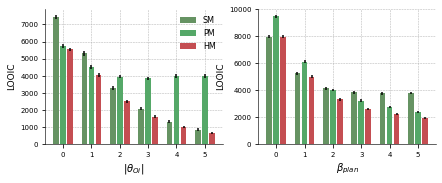

In [35]:
barx_simple = np.arange(0,21,4)
barx_planning = np.arange(0,21,4)+1
barx_hybrid = np.arange(0,21,4)+2
xticks = np.arange(0,21,4)+1
xticklabels = np.arange(0,6)

fig, ax = plt.subplots(1,2,figsize=(7,2.5))
for i,axes in enumerate(ax.flat):
    if i == 0:
        axes.bar(barx_simple,looic_simple_i_vary_theta,yerr=looic_simple_se_i_vary_theta,label='SM')
        axes.bar(barx_planning,looic_planning_i_vary_theta,yerr=looic_planning_se_i_vary_theta,label='PM')
        axes.bar(barx_hybrid,looic_hybrid_i_vary_theta,yerr=looic_hybrid_se_i_vary_theta,label='HM')
        axes.set_xlabel(r'|$\theta_{O i}$|', fontsize=10);
        axes.legend(frameon=False)

    if i == 1:
        axes.bar(barx_simple,looic_simple_i_vary_beta,yerr=looic_simple_se_i_vary_beta)
        axes.bar(barx_planning,looic_planning_i_vary_beta,yerr=looic_planning_se_i_vary_beta)
        axes.bar(barx_hybrid,looic_hybrid_i_vary_beta,yerr=looic_hybrid_se_i_vary_beta)
        axes.set_xlabel(r'$\beta_{plan}$', fontsize=10);
        
    axes.set_ylabel('LOOIC')
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticklabels)

#fig.savefig('model_recovery', dpi=300, bbox_inches='tight', transparent=False)